In [1]:
from collections import OrderedDict
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot(t, x):
    if x is None:
        plt.plot()
    else:
        t_plt = t[~x.isna()]
        x_plt = x[~x.isna()]
        plt.plot(t_plt, x_plt)


def plot_learning_curves(datasets: OrderedDict, name: str):
    plt.figure(figsize=(10, 7))

    for _, path in datasets.items():
        df = pd.read_csv(path / "progress.csv")
        plot(df.get("env_steps"), df.get("return"))

    plt.title(f"Learning Curve for {name}")
    plt.xlabel("env_steps")
    plt.ylabel("return")
    plt.legend(datasets.keys())
    plt.show()


def plot_loss_and_learning_curves(datasets: OrderedDict, name: str):
    n_items = len(datasets)
    c = 1

    plt.figure(figsize=(15, 10))

    for i, (name, path) in enumerate(datasets.items()):
        df = pd.read_csv(path / "progress.csv")
        with open(path / "flags.yml", "r") as f:
            cfg = yaml.load(f, Loader=yaml.SafeLoader)

        env_steps = df.get("env_steps")

        plt.subplot(3, n_items, i + 1)
        c += 1
        plot(env_steps, df["return"])
        plt.xlabel("env_steps")
        plt.ylabel("return")
        plt.title(f"Learning Curve for {name}")

        plt.subplot(3, n_items, n_items + i + 1)
        gamma = cfg.get("bisim_gamma")
        unscaled_transition_dist = df.get("transition_dist")
        if gamma is not None and unscaled_transition_dist is not None:
            transition_dist = gamma * unscaled_transition_dist
        else:
            transition_dist = None
        c += 1
        plot(env_steps, df.get("r_dist"))
        plot(env_steps, transition_dist)
        plt.xlabel("env_steps")
        plt.ylabel("bisim component")
        plt.title(f"Bisimulation Distance Components for {name}")
        plt.legend(["r_dist", "transition_dist"])

        plt.subplot(3, n_items, 2 * n_items + i + 1)
        bisimilarity = (
            None if transition_dist is None else df.get("r_dist") + transition_dist
        )
        c += 1
        plot(env_steps, df.get("z_dist"))
        plot(env_steps, bisimilarity)
        plt.xlabel("env_steps")
        plt.ylabel("loss component")
        plt.title(f"Bisimulation Loss Components for {name}")
        plt.legend(["z_dist", "bisimilarity"])

    plt.suptitle(f"Loss Components and Learning Curves for {name}", fontsize=16)
    plt.show()


def plot_encoder_signals(datasets: OrderedDict, name: str):
    n_items = len(datasets)
    plt.figure(figsize=(15, 10))

    for i, (dataset_name, dataset_path) in enumerate(datasets.items()):
        df = pd.read_csv(dataset_path / "progress.csv")

        env_steps = df.get("env_steps")

        plt.subplot(3, n_items, i + 1)
        plot(env_steps, df["alm_loss"])
        plot(env_steps, df["aux_loss"])
        plt.xlabel("env_steps")
        plt.ylabel("loss")
        plt.title(f"Total Encoder Loss for {dataset_name}")
        plt.legend(["alm_loss", "aux_loss"])

        plt.subplot(3, n_items, n_items + i + 1)
        plot(env_steps, df.get("bisim_critic_loss"))
        plt.xlabel("env_steps")
        plt.ylabel("loss")
        plt.title(f"Bisim Critic Loss for {dataset_name}")

        plt.subplot(3, n_items, 2 * n_items + i + 1)
        plot(env_steps, df["critic_loss"])
        plt.xlabel("env_steps")
        plt.ylabel("loss")
        plt.title(f"Agent Critic Loss for {dataset_name}")

    plt.suptitle(f"Encoder Signals for {name}", fontsize=16)
    plt.show()


def plot_combined_metrics(datasets: OrderedDict, name: str):
    n_items = len(datasets)
    plt.figure(figsize=(15, 20))  # Increased height to accommodate 4 rows

    for i, (dataset_name, dataset_path) in enumerate(datasets.items()):
        df = pd.read_csv(dataset_path / "progress.csv")
        with open(dataset_path / "flags.yml", "r") as f:
            cfg = yaml.load(f, Loader=yaml.SafeLoader)

        env_steps = df.get("env_steps")
        gamma = cfg.get("bisim_gamma")
        unscaled_transition_dist = df.get("transition_dist")
        if gamma is not None and unscaled_transition_dist is not None:
            transition_dist = gamma * unscaled_transition_dist
        else:
            transition_dist = None
        bisimilarity = (
            None if transition_dist is None else df.get("r_dist") + transition_dist
        )

        # 1) return
        plt.subplot(4, n_items, i + 1)
        plot(env_steps, df["return"])
        plt.xlabel("env_steps")
        plt.ylabel("return")
        plt.title(f"Learning Curve for {dataset_name}")

        # 2) alm_loss and aux_loss
        plt.subplot(4, n_items, n_items + i + 1)
        plot(env_steps, df["alm_loss"])
        plot(env_steps, df["aux_loss"])
        plt.xlabel("env_steps")
        plt.ylabel("loss")
        plt.title(f"Encoder Losses for {dataset_name}")
        plt.legend(["alm_loss", "aux_loss"])

        # 3) r_dist and transition_dist
        plt.subplot(4, n_items, 2 * n_items + i + 1)
        plot(env_steps, df.get("r_dist"))
        if transition_dist is not None:
            plot(env_steps, transition_dist)
        plt.xlabel("env_steps")
        plt.ylabel("distance")
        plt.title(f"Bisimulation Distance Components for {dataset_name}")
        plt.legend(["r_dist", "transition_dist"])

        # 4) z_dist and bisimilarity
        plt.subplot(4, n_items, 3 * n_items + i + 1)
        plot(env_steps, df.get("z_dist"))
        if bisimilarity is not None:
            plot(env_steps, bisimilarity)
        plt.xlabel("env_steps")
        plt.ylabel("distance/loss")
        plt.title(f"Bisimulation Loss Components for {dataset_name}")
        plt.legend(["z_dist", "bisimilarity"])

    plt.suptitle(f"Combined Metrics for {name}", fontsize=16)
    plt.tight_layout()
    plt.show()

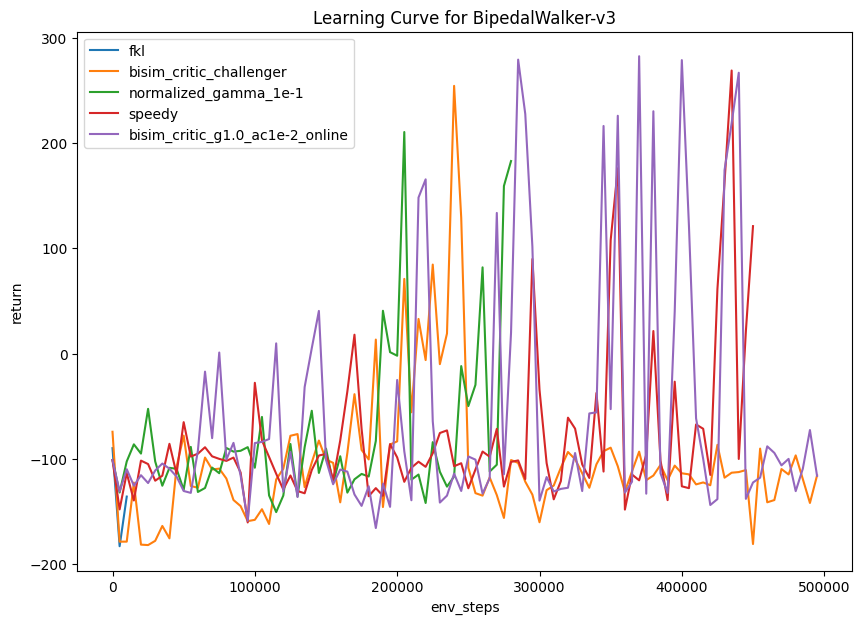

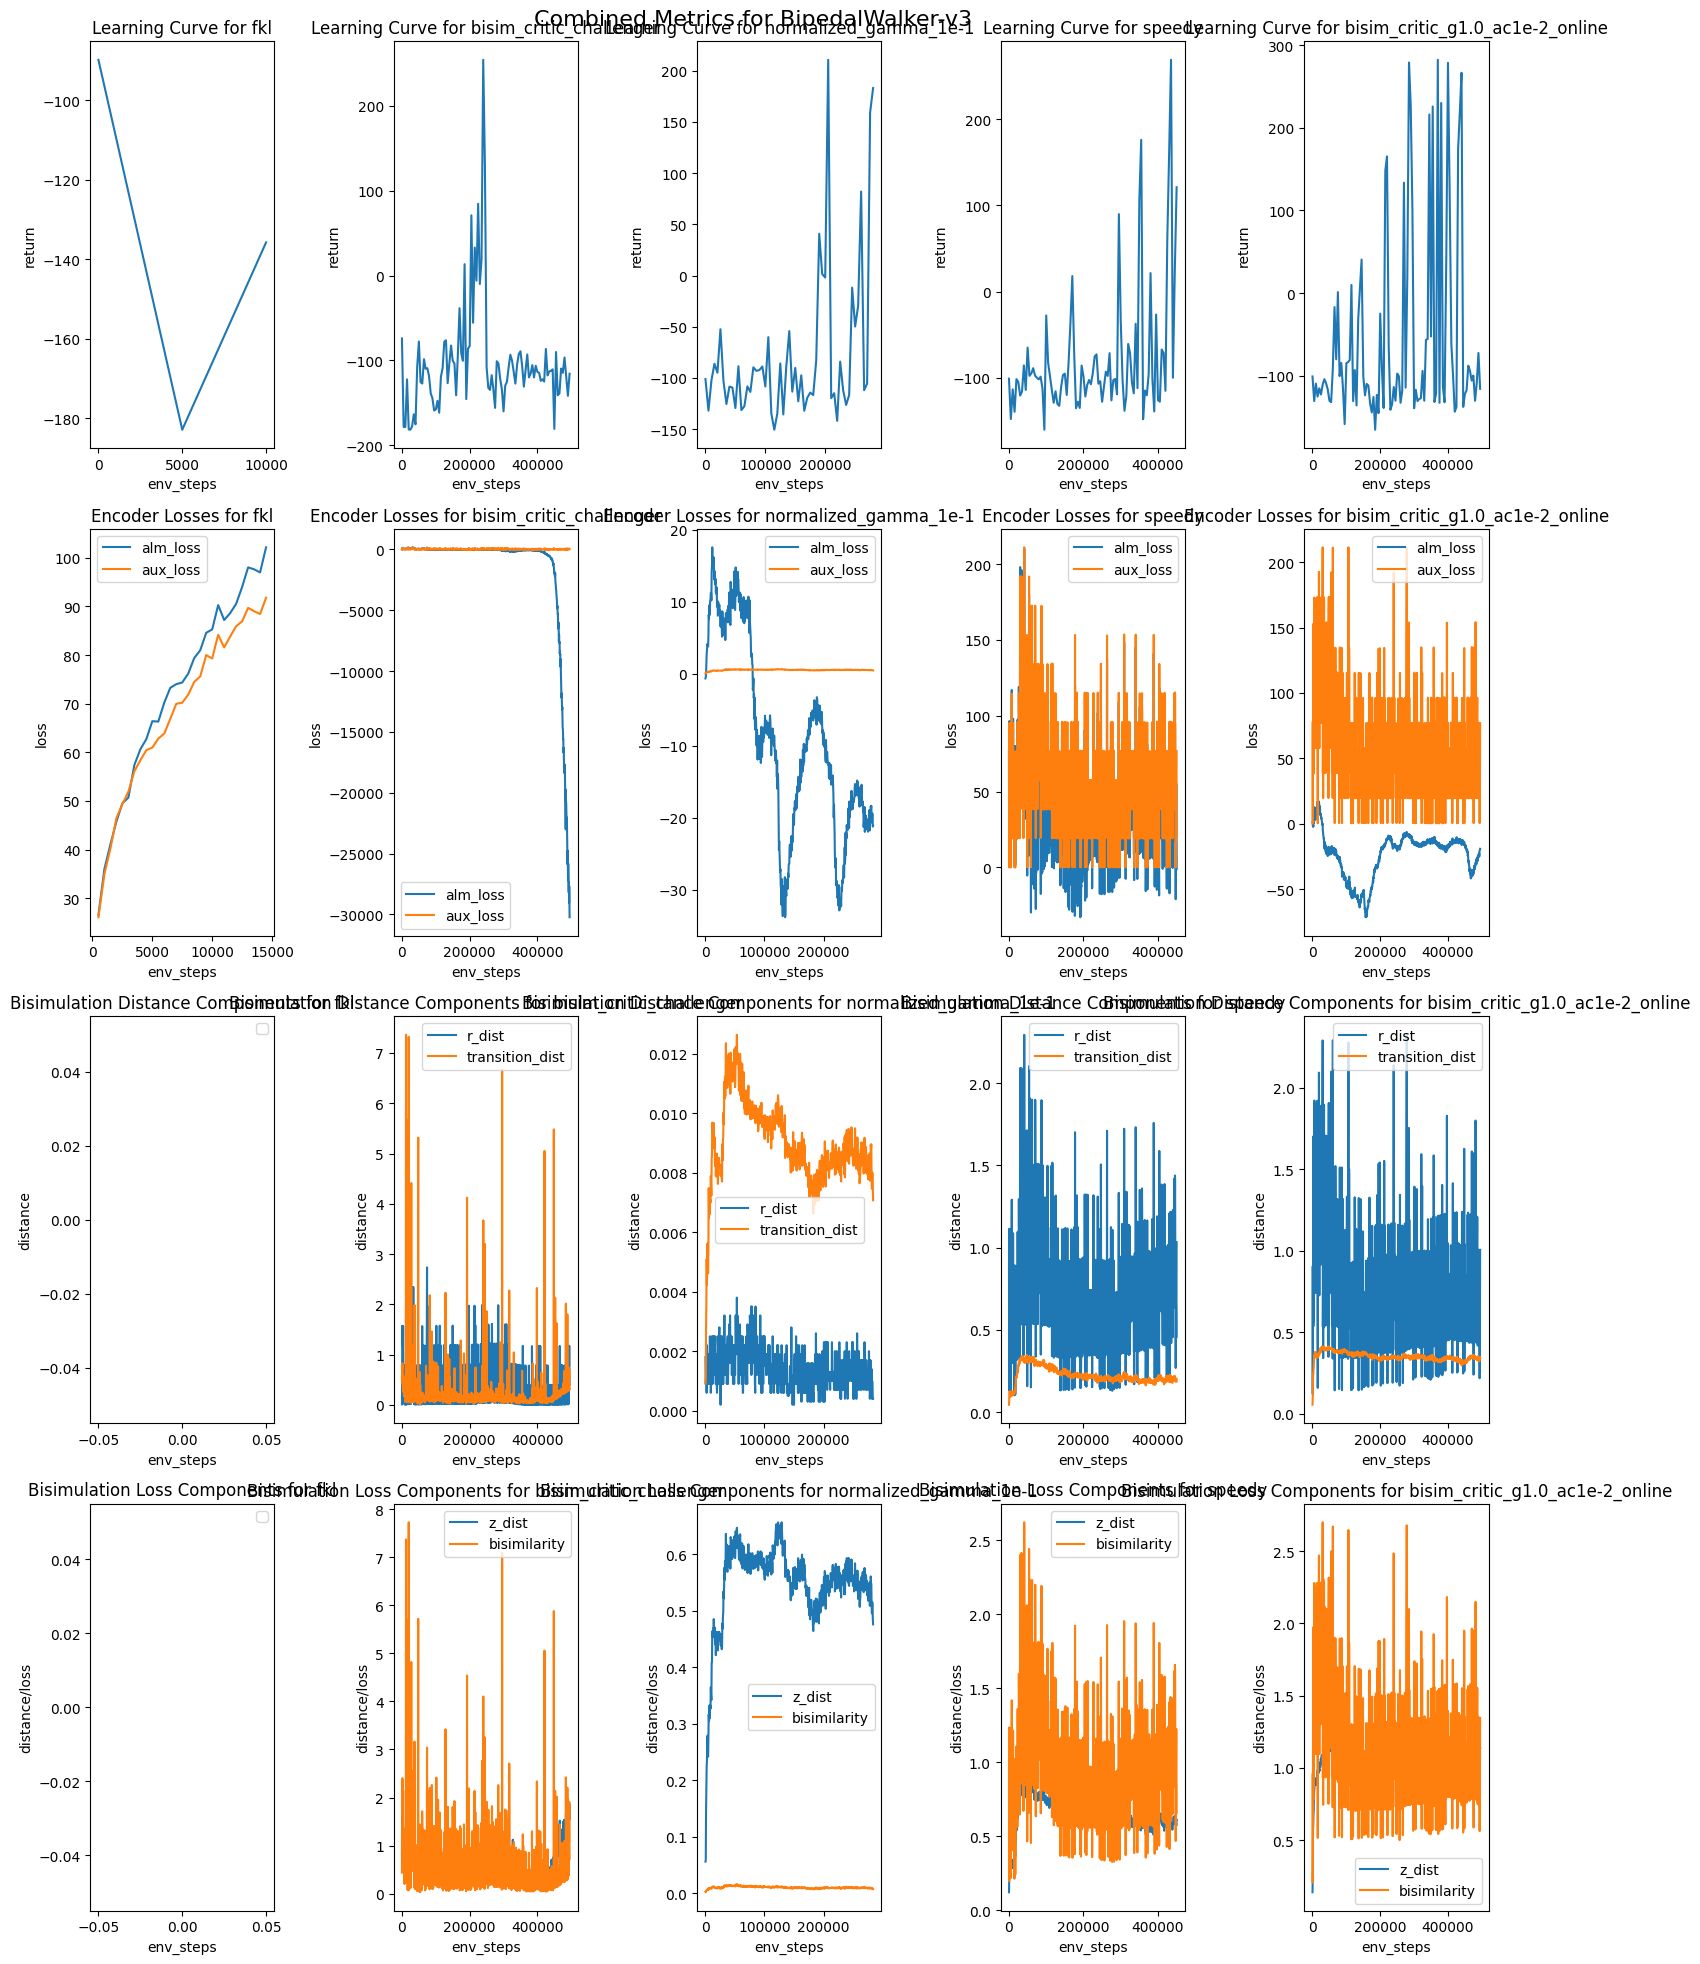

In [3]:
bipedalwalker_datasets = OrderedDict(
    [
        (
            "fkl",
            Path("./logs/BipedalWalker-v3/2024-10-10-00-45-42+63393-63393/"),
        ),
        # (
        #     # "bisim_critic_15",
        #     "first_working",
        #     Path("./logs/BipedalWalker-v3/2024-10-10-12-54-00+34348-34348/"),
        # ),
        (
            "bisim_critic_challenger",
            Path("./logs/BipedalWalker-v3/2024-10-11-23-32-24+54874-54874/"),
        ),
        # (
        #     "bisim_critic_gamma_5e-3",
        #     Path("./logs/BipedalWalker-v3/2024-10-12-11-23-24+69174-69174/"),
        # ),
        # (
        #     "bisim_critic_gamma_5e-3_det",
        #     Path("./logs/BipedalWalker-v3/2024-10-12-22-11-42+81855-81855/"),
        # ),
        # (
        #     "bisim_critic_gamma_5e-3_det_scalarized",
        #     Path("./logs/BipedalWalker-v3/2024-10-13-09-11-48+92850-92850/"),
        # ),
        # (
        #     "bisim_critic_gamma_5e-3_sto_scalarized",
        #     Path("./logs/BipedalWalker-v3/2024-10-13-17-58-53+614099-614099/"),
        # ),
        # (
        # "bisim_critic_gamma_5e-3_sto_scalarized_l2",
        #     Path("./logs/BipedalWalker-v3/2024-10-13-21-03-20+13823-13823/"),
        # ),
        # (
        #     "bisim_critic_gamma_5e-3_sto_vec_l1_online",
        #     Path("./logs/BipedalWalker-v3/2024-10-13-21-38-31+15579-15579/"),
        # ),
        # (
        #     # "bisim_critic_gamma_5e-3_sto_scalarize_l2_exact",
        #     "exact",
        #     Path("./logs/BipedalWalker-v3/2024-10-14-04-17-15+668866-668866/")
        # ),
        # (
        #     #"bisim_critic_gamma_5e-3_sto_scalarize_l2_exact_1step",
        #     "challenger",
        #     Path("./logs/BipedalWalker-v3/2024-10-14-16-12-16+1912462-1912462/")
        # ),
        # (
        #     "normalized_gamma_1",
        #     Path("./logs/BipedalWalker-v3/2024-10-14-21-08-42+8482-8482/")
        # ),
        # (
        #     "normalized_gamma_1e-3",
        #     Path("./logs/BipedalWalker-v3/2024-10-14-21-14-31+16298-16298/")
        # ),
        (
            "normalized_gamma_1e-1",
            Path("./logs/BipedalWalker-v3/2024-10-14-21-17-22+17251-17251/"),
        ),
        (
            "speedy",
            Path("./logs/BipedalWalker-v3/2024-10-15-14-18-31+1041701-1041701/"),
        ),
        (
            "bisim_critic_g1.0_ac1e-2_online",
            Path("./logs/BipedalWalker-v3/2024-10-15-17-22-05+1357975-1357975/"),
        ),
    ]
)

plot_learning_curves(bipedalwalker_datasets, "BipedalWalker-v3")
# plot_loss_and_learning_curves(bipedalwalker_datasets, "BipedalWalker-v3")
# plot_encoder_signals(bipedalwalker_datasets, "BipedalWalker-v3")
plot_combined_metrics(bipedalwalker_datasets, "BipedalWalker-v3")

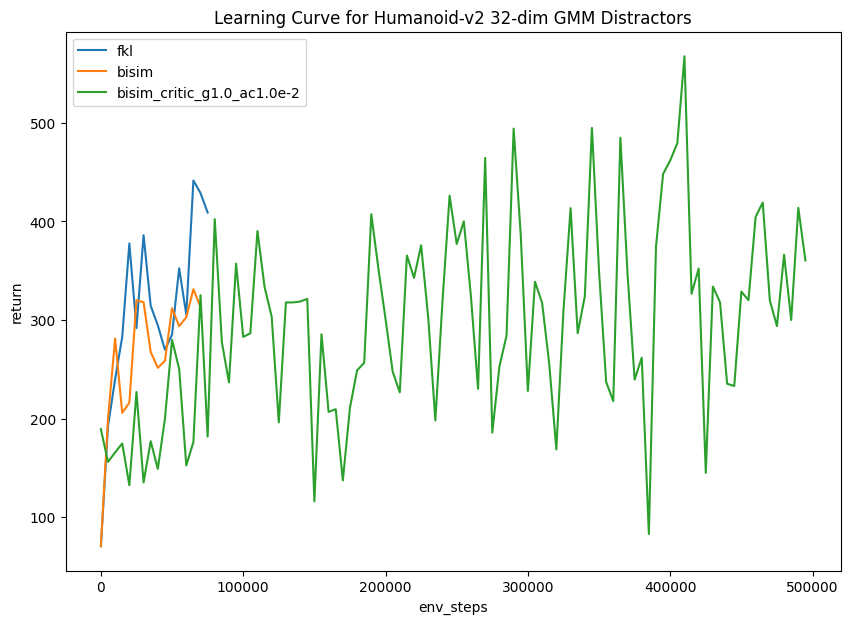

In [4]:
humanoid_datasets = OrderedDict(
    [
        (
            "fkl",
            Path("./logs/Humanoid-v2-d32/2024-10-10-00-04-13+10923-10923"),
        ),
        (
            "bisim",
            Path("./logs/Humanoid-v2-d32/2024-10-10-00-04-24+10982-10982"),
        ),
        (
            "bisim_critic_g1.0_ac1.0e-2",
            Path("./logs/Humanoid-v2-d32/2024-10-16-06-08-41+2675481-2675481/"),
        ),
    ]
)

plot_learning_curves(humanoid_datasets, "Humanoid-v2 32-dim GMM Distractors")

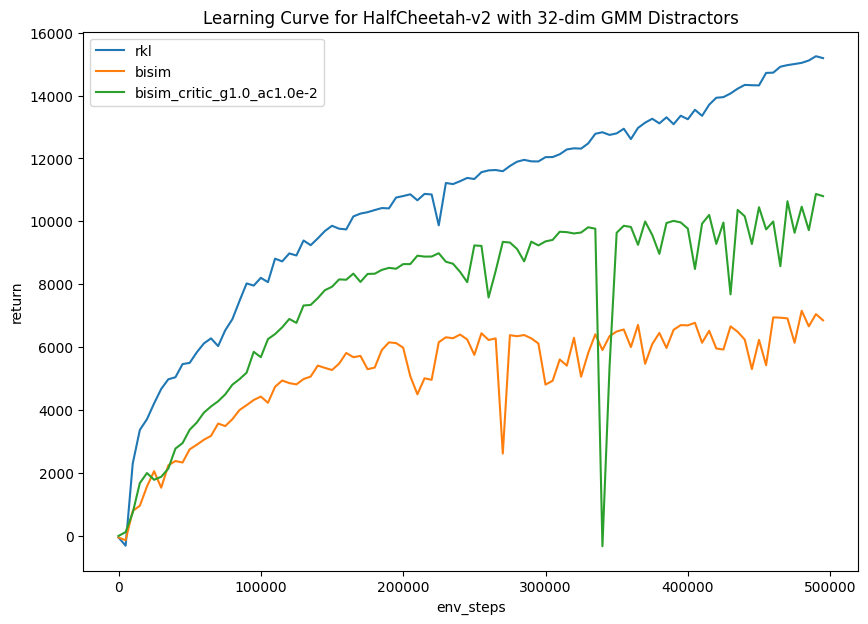

In [5]:
halfcheetah_datasets = OrderedDict(
    [
        (
            "rkl",
            Path("./logs/HalfCheetah-v2-d32/2024-10-09-14-50-12+1929748-1929748"),
        ),
        (
            "bisim",
            Path("./logs/HalfCheetah-v2-d32/2024-10-09-14-48-21+1926890-1926890"),
        ),
        (
            "bisim_critic_g1.0_ac1.0e-2",
            Path("./logs/HalfCheetah-v2-d32/2024-10-16-02-59-15+2350151-2350151/"),
        ),
    ]
)

plot_learning_curves(halfcheetah_datasets, "HalfCheetah-v2 with 32-dim GMM Distractors")

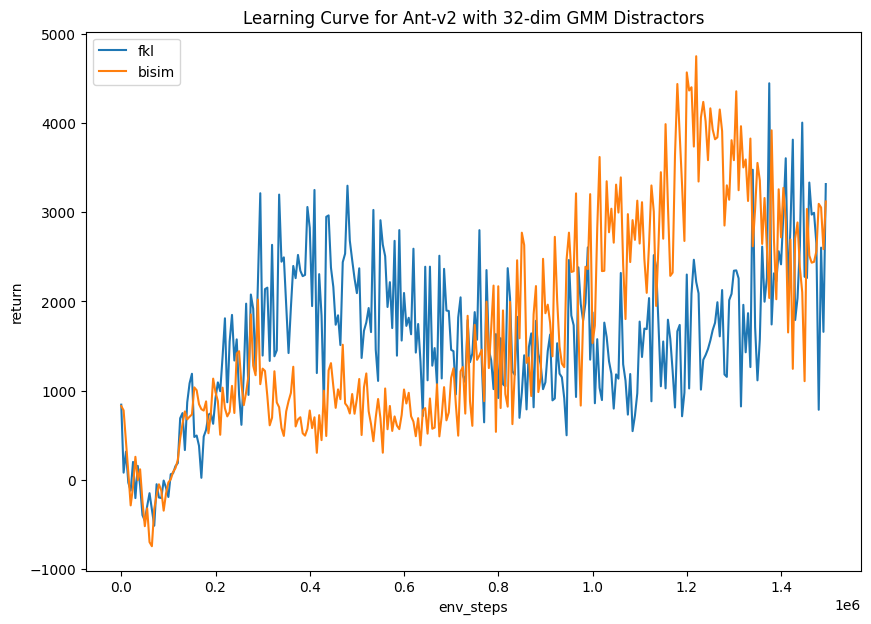

In [6]:
ant_datasets = OrderedDict(
    [
        ("fkl", Path("logs/Ant-v2-d32/2024-10-08-14-37-29+5513-5513")),
        ("bisim", Path("logs/Ant-v2-d32/2024-10-08-14-37-48+6123-6123")),
    ]
)

plot_learning_curves(ant_datasets, "Ant-v2 with 32-dim GMM Distractors")

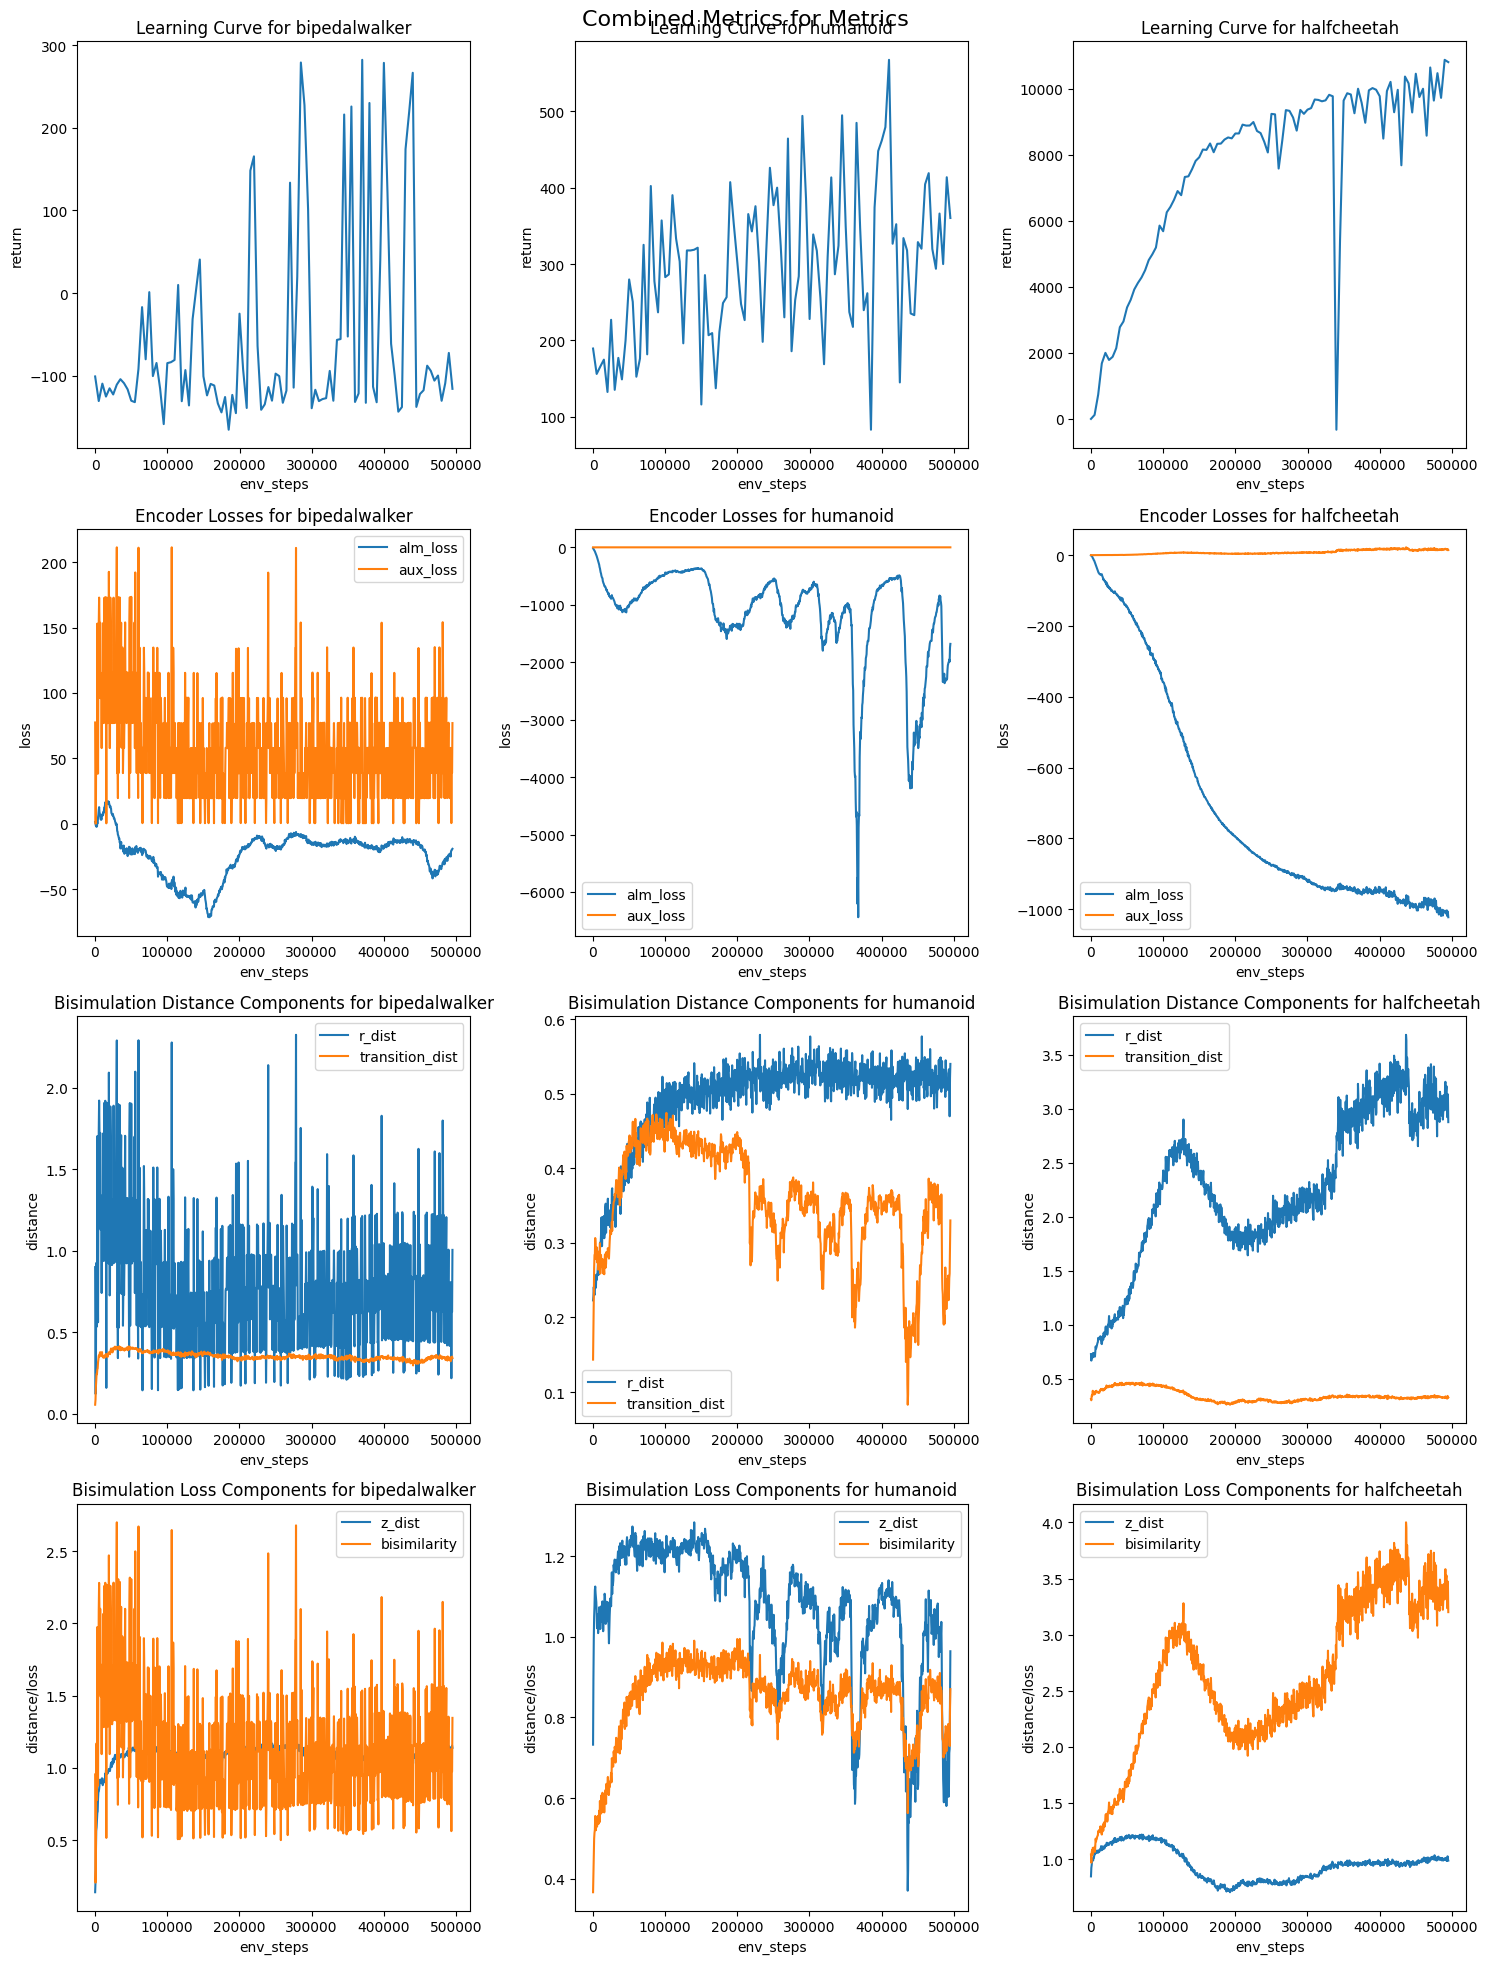

In [7]:
cmp_datasets = OrderedDict(
    [
        (
            "bipedalwalker",
            Path("./logs/BipedalWalker-v3/2024-10-15-17-22-05+1357975-1357975/"),
        ),
        (
            "humanoid",
            Path("./logs/Humanoid-v2-d32/2024-10-16-06-08-41+2675481-2675481/"),
        ),
        (
            "halfcheetah",
            Path("./logs/HalfCheetah-v2-d32/2024-10-16-02-59-15+2350151-2350151/"),
        ),
    ]
)

plot_combined_metrics(cmp_datasets, "Metrics")

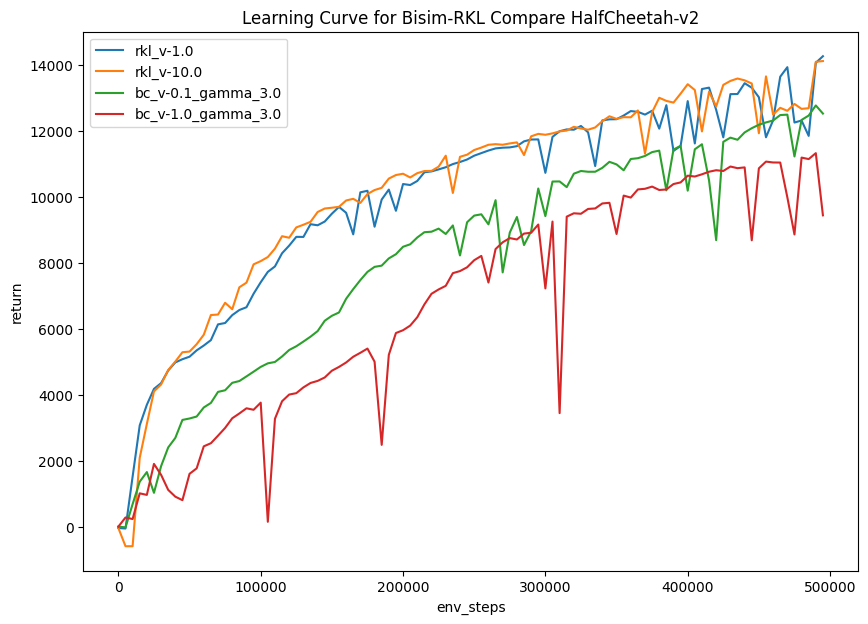

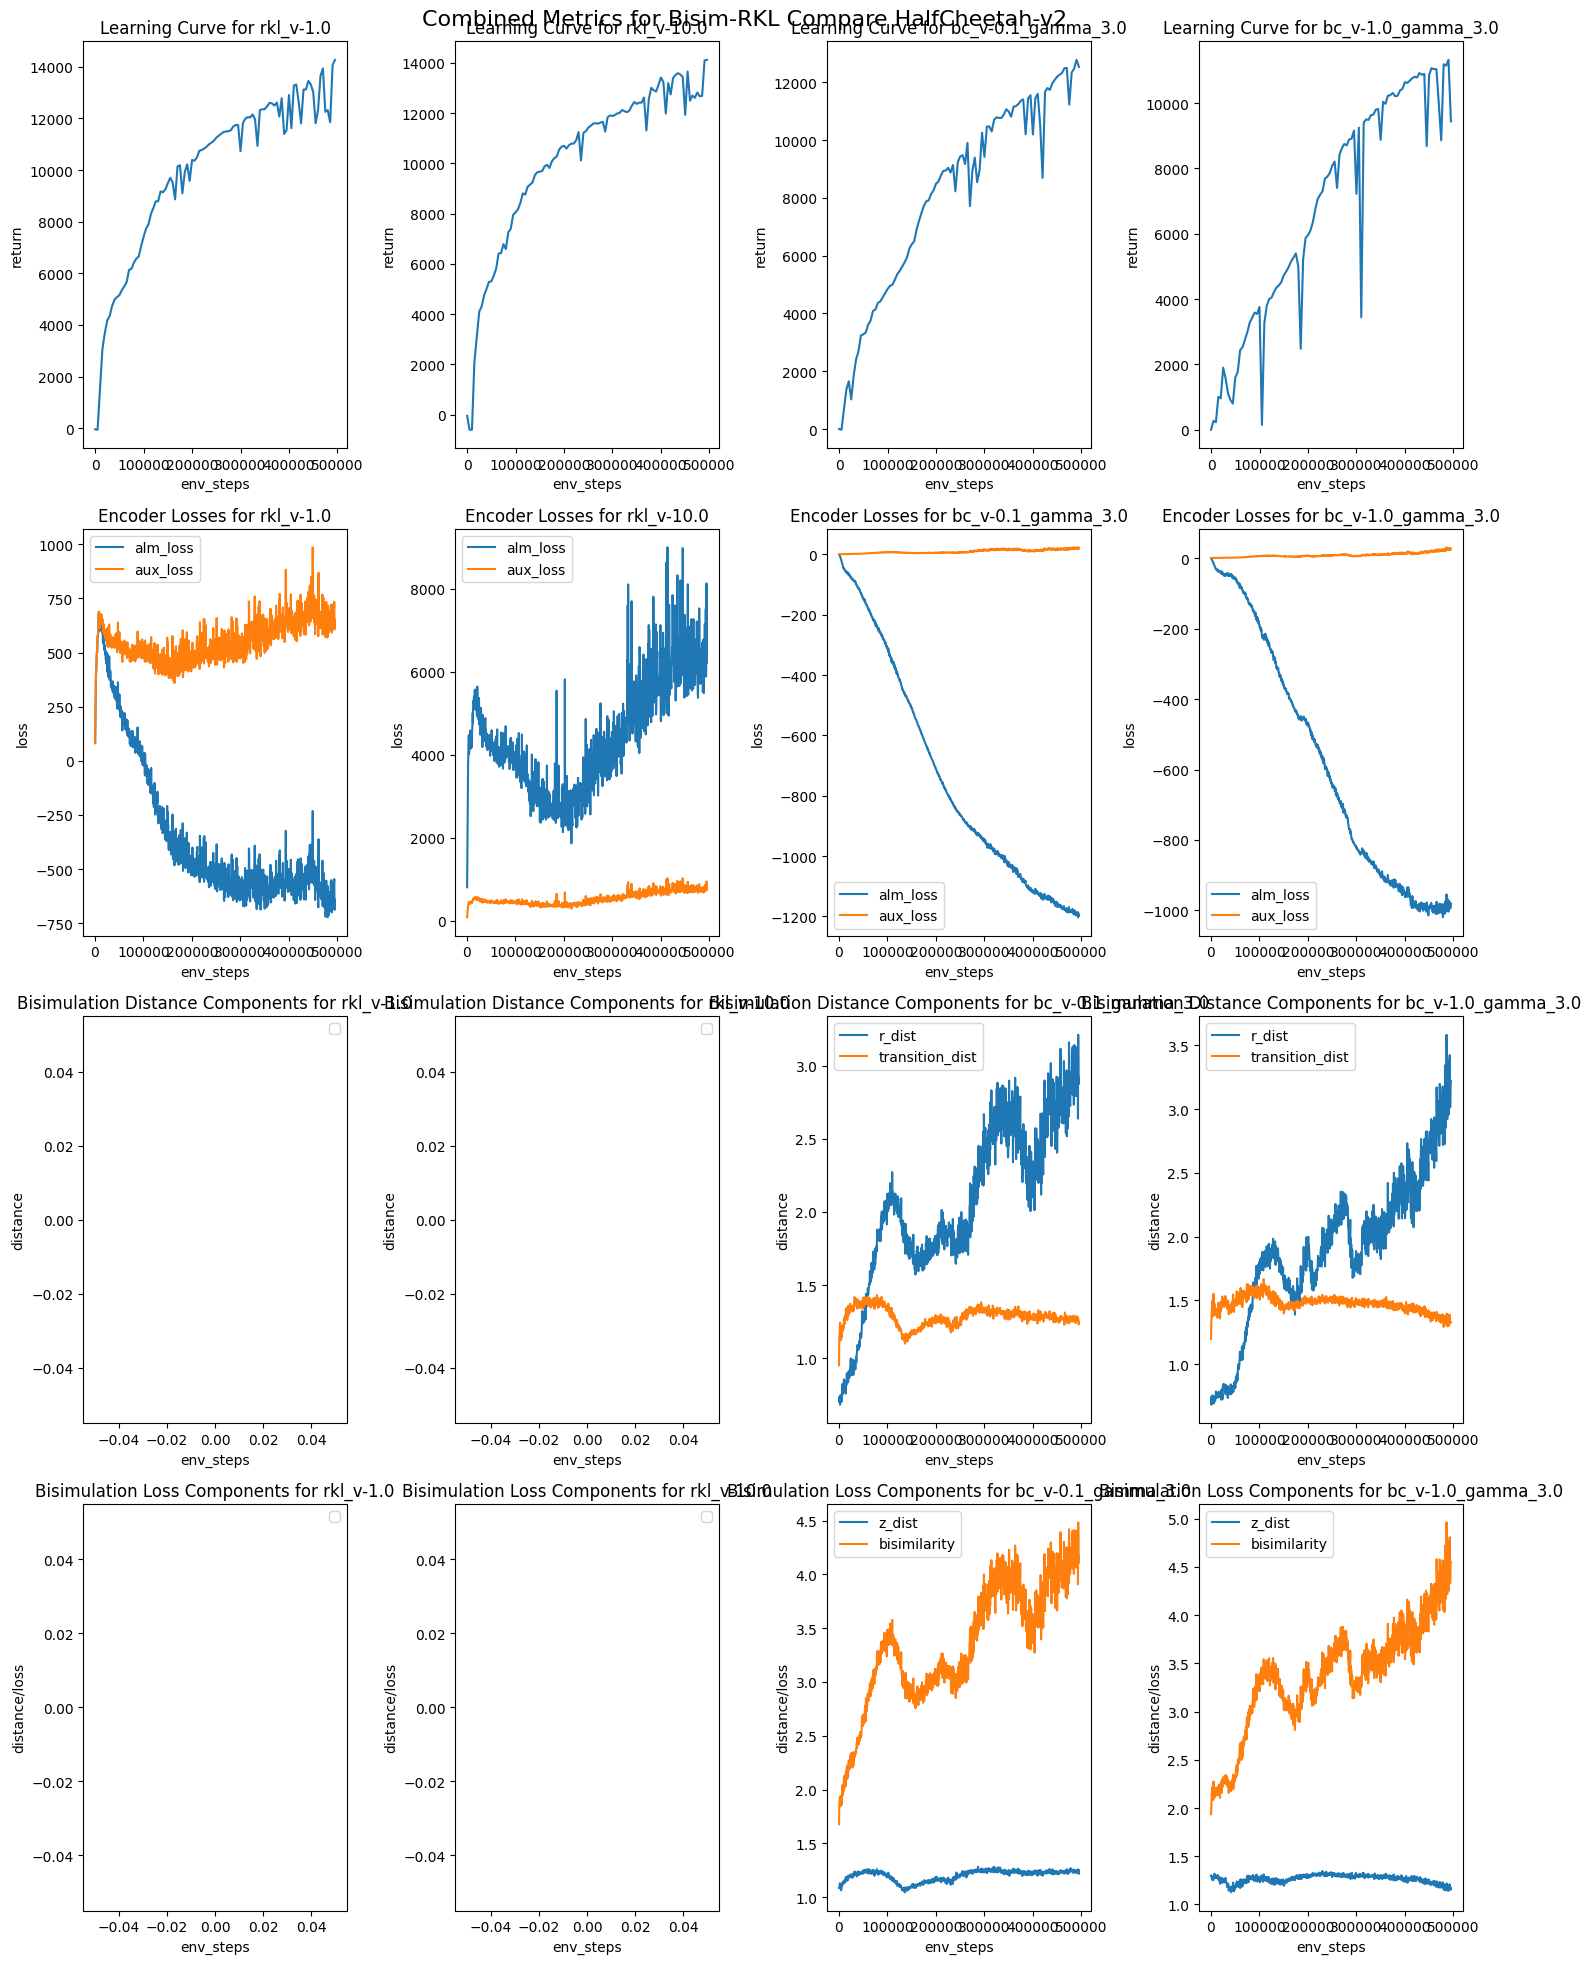

In [8]:
bisim_rkl_datasets = OrderedDict(
    [
        (
            "rkl_v-1.0",
            Path("./logs/HalfCheetah-v2-d32/2024-10-16-13-34-12+26721-26721/"),
        ),
        (
            "rkl_v-10.0",
            Path("./logs/HalfCheetah-v2-d32/2024-10-16-13-35-28+29176-29176/"),
        ),
        (
            "bc_v-0.1_gamma_3.0",
            Path("./logs/HalfCheetah-v2-d32/2024-10-16-13-23-10+7866-7866/"),
        ),
        (
            "bc_v-1.0_gamma_3.0",
            Path("./logs/HalfCheetah-v2-d32/2024-10-16-13-24-48+12015-12015/"),
        ),
    ]
)

plot_learning_curves(bisim_rkl_datasets, "Bisim-RKL Compare HalfCheetah-v2")
plot_combined_metrics(bisim_rkl_datasets, "Bisim-RKL Compare HalfCheetah-v2")

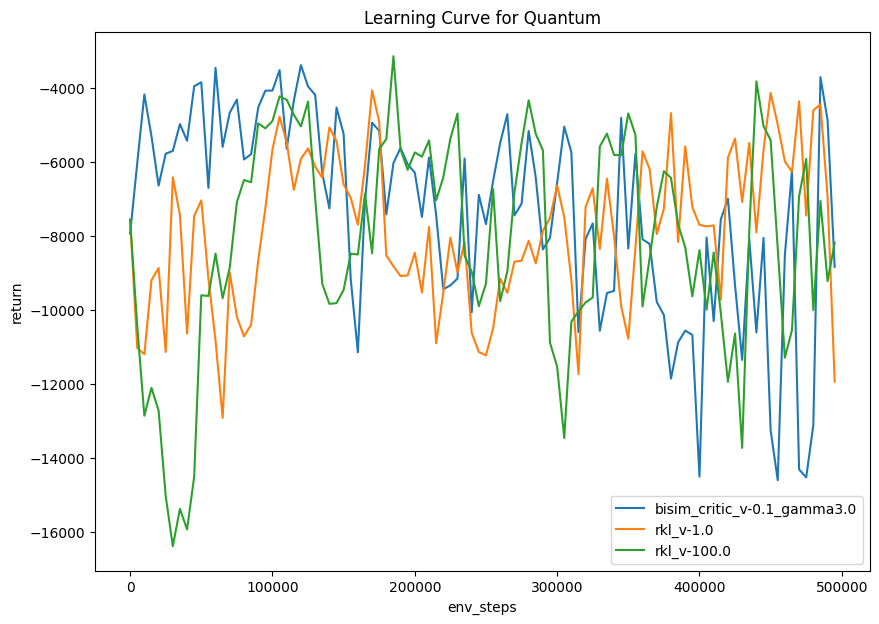

In [11]:
quantum_datasets = OrderedDict(
    [
        (
            "bisim_critic_v-0.1_gamma3.0",
            Path(
                "./logs/QuantumParticleNavigator-v0/2024-10-16-17-27-11+348501-348501/"
            ),
        ),
        (
            "rkl_v-1.0",
            Path(
                "./logs/QuantumParticleNavigator-v0/2024-10-16-17-32-41+3851623-3851623/"
            ),
        ),
        (
            "rkl_v-100.0",
            Path(
                "./logs/QuantumParticleNavigator-v0/2024-10-16-17-32-51+3852532-3852532/"
            ),
        ),
    ]
)

plot_learning_curves(quantum_datasets, "Quantum")